# Anomalie Detection Filling Station

Thi notebook is part of the Master's thesis "Anomalieerkennung in industriellen Produktionsprozessen mit
Transformer-Modellen". Further information for pre-processing, model and evaluation can be found in this Master's thesis. 

In [1]:
import sys 
sys.path.append('../')
import copy

import numpy as np
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 8]
import sklearn
import seaborn as sns

import timeserieslibrary.Transformer_Model as tm
import timeserieslibrary.Preprocessing as pp
import timeserieslibrary.Learning_Rate_Schedule as lrs


print("is GPU:",tf.test.is_gpu_available())
print("is cuda:",tf.test.is_built_with_cuda())
print(tf.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
is GPU: True
is cuda: True
2.10.0


# Load the Data


In [2]:
#Trainings Data
data_normal_train1 = pd.read_csv("Daten/Normal/Normal.csv")
data_normal_train2 = pd.read_csv("Daten/Normal/Normal3.csv")
data_normal_train3 = pd.read_csv("Daten/Normal/Normal_Auslauf.csv")
data_normal_train4 = pd.read_csv("Daten/Normal/StartUp.csv")
data_normal_train5 = pd.read_csv("Daten/Normal/Normal_Wenig_Flaschen.csv")
#Combine all trainings data
data_normal_train = pd.concat((data_normal_train1, data_normal_train2, data_normal_train3, data_normal_train4, data_normal_train5))

#Normal Validation Data
data_normal_valid = pd.read_csv("Daten/Normal/Normal2.csv")

#Normal Test Data
data_test_normal = pd.read_csv("Daten/Normal/Normal4.csv")


#Anomalie Data
data_test_drehtisch_widerstand1=pd.read_csv("Daten/Anomalie/Rondel_Wiederstand.csv")
data_test_drehtisch_widerstand2=pd.read_csv("Daten/Anomalie/Rondel_Wiederstand2.csv")
data_test_drehtisch_widerstand = data_test_drehtisch_widerstand1 #pd.concat((data_test_drehtisch_widerstand1, data_test_drehtisch_widerstand2))
data_test_drehtisch_blockiert = pd.read_csv("Daten/Anomalie/Rondel_Blockiert.csv")
data_test_drehtisch_zu_wenig_widerstand = pd.read_csv("Daten/Anomalie/Rondel_zu_wenig_wiederstand.csv")
data_test_widerstand_transportband = pd.read_csv("Daten/Anomalie/Widerstand_Transport.csv")
data_test_widerstand_zufuerband = pd.read_csv("Daten/Anomalie/Wiederstand_Zuführ.csv")

data_test_widerstand_ronde_schleichend = pd.read_csv("Daten/Anomalie/Synthetic_Rondel_Schleichende_Widerstands_Erhöhung.csv")
data_test_widerstand_transport_schleichend = pd.read_csv("Daten/Anomalie/Synthetic_Transportförderband_Schleichende_Widerstands_Erhöhung.csv")

#Cobine all test data
all_test_data = [data_test_normal, data_test_drehtisch_widerstand, data_test_drehtisch_blockiert, data_test_drehtisch_zu_wenig_widerstand, data_test_widerstand_transportband, data_test_widerstand_ronde_schleichend, data_test_widerstand_transport_schleichend]
all_test_data_names=["Normal", "Drehtisch Widerstand",  "Drehtisch Blockiert", "Drehtisch zu wenig widerstand", "Transportband Widerstand", "Schleichender Fehler Rondel", "Schleichender Fehler Förderband"]

In [3]:
data_test_widerstand_ronde_schleichend.columns

Index(['Timestamp', 'Drucksensor', 'Gesamtstrom', 'Ansteuerung Förderband',
       'Ansteuerung Drehtisch', 'Ansteuerung Zuführförderband',
       'Obere Position Greifer Erreicht', 'Untere Position Greifer Erreicht',
       'Boolwert ob die Position des Separators für Flüssigkeiten geschlossen ist',
       'Boolwert ob die Position des Separators für Feststoffen geschlossen ist',
       'Boolwert zur Ansteuerung des Separators für Flüssigkeiten',
       'Boolwert zur Ansteuerung des Separators für Feststoffe',
       'Integerwert für den Motorstrom am Transportförderband',
       'Integerwert für den Motorstrom am Zuführförderband',
       'Integerwert für den Motorstrom am Drehtisch',
       'Integerwert für die Raumtemperatur',
       'Integerwert für die Temperatur am Motorgehäuse des Transportförderbands',
       'Boolwert zur Ansteuerung des Flaschenfixierers',
       'Boolwert zur Ansteuerung des der Greiferbacken',
       'Boolwert zur Einleitung der Greifer-Verfahrbewegung nac

In [4]:
print("Trainings Data Shape:", data_normal_train.shape)
print("Validation Data Shape:", data_normal_valid.shape)

for variable, testdata in enumerate(all_test_data):
    print(all_test_data_names[variable], "Test Data Shape:", testdata.shape)

Trainings Data Shape: (404296, 22)
Validation Data Shape: (108519, 22)
Normal Test Data Shape: (71926, 22)
Drehtisch Widerstand Test Data Shape: (24231, 22)
Drehtisch Blockiert Test Data Shape: (11164, 22)
Drehtisch zu wenig widerstand Test Data Shape: (14416, 22)
Transportband Widerstand Test Data Shape: (12636, 22)
Schleichender Fehler Rondel Test Data Shape: (53333, 22)
Schleichender Fehler Förderband Test Data Shape: (53333, 22)


In [5]:
print(data_normal_train.shape)
print(data_normal_valid.shape)
print(data_test_normal.shape)

(404296, 22)
(108519, 22)
(71926, 22)


In [6]:
print(data_test_drehtisch_widerstand.shape)
print(data_test_drehtisch_blockiert.shape)
print(data_test_drehtisch_zu_wenig_widerstand.shape)
print(data_test_widerstand_transportband.shape)

(24231, 22)
(11164, 22)
(14416, 22)
(12636, 22)


In [7]:
input_variablen = range(1,17,1)#
bool_variablen= [3,4,5,6,7,8,9,10,11,17,18,19,20,21]
ground_truth_variable= [2,12,14]
name_list = list(data_normal_valid.columns.values.tolist())

name_dict = {} 
for variable in range(len(name_list)):
    name_dict[variable]=name_list[variable]

In [8]:
variablen_to_mask_index_list=[]
for variable in ground_truth_variable:
    variablen_to_mask_index_list += [np.where(np.array(input_variablen) == variable)]

In [9]:

ground_truth_name_list=[name_list[i] for i in ground_truth_variable]
ground_truth_variable_names = [name_dict[j] for j in ground_truth_variable]
print(ground_truth_variable_names)

['Gesamtstrom', 'Integerwert für den Motorstrom am Transportförderband', 'Integerwert für den Motorstrom am Drehtisch']


# Preprocess Data

In [10]:
input_window=64
sliding_window_step=1
downsampling_faktor=64
mask_input_data=True
scale_data=True
add_time_stamp=True
data_multiplicator_for_masking = 4
data_mask_lenght=0.5

In [11]:
#Window_lenght_in_ms
original_sample_time=6
window_time=original_sample_time*downsampling_faktor*input_window
print("window time", np.round(window_time/1000, 2))

window time 24.58


In [12]:
#ts_processing = pp.TimeSeriesPreprocessingPipeline(  JSON_config_file="preprocessing_config.json")
                                                 
ts_processing = pp.TimeSeriesPreprocessingPipeline(  split_time_series_into_window_of_len=input_window, 
                                             input_variable_index_list=input_variablen, 
                                             downsampling_faktor=downsampling_faktor,       
                                             index_list_bool_variablen=bool_variablen,                                       
                                             sliding_window_step=sliding_window_step, 
                                             add_time_stamp=add_time_stamp, 
                                             scale_data=scale_data,                                            
                                             ground_truth_variable_index_list=ground_truth_variable,
                                             mask_input_data=mask_input_data,
                                             data_mask_lenght=data_mask_lenght,
                                             data_multiplicator_for_masking=data_multiplicator_for_masking,
                                             )


x_train, y_train = ts_processing(data_normal_train, is_test_data=False)
x_valid, y_valid = ts_processing(data_normal_valid, is_test_data=True)

ts_processing.save_config_as_JSON()


Input data shape: (404296, 22)
Shape of x data (25020, 64, 17)
Shape of y data (25020, 64, 3)

Input data shape: (108519, 22)
Shape of x data (1633, 64, 17)
Shape of y data (1633, 64, 3)


for variable in range(x_train.shape[-1]-1):
    
    print("Variable:", name_list[input_variablen[variable]])
    plt.plot(x_train[1,:,variable])
    plt.show()

In [13]:
test_data_preprocessed_x = []
test_data_preprocessed_y= []
for variable in all_test_data:
    x_, y_= ts_processing(variable, stride_of_window = 1, is_test_data=True)
    test_data_preprocessed_x += [np.array(x_,dtype=np.float32)]
    test_data_preprocessed_y += [np.array(y_,dtype=np.float32)]



Input data shape: (71926, 22)
Shape of x data (1061, 64, 17)
Shape of y data (1061, 64, 3)

Input data shape: (24231, 22)
Shape of x data (316, 64, 17)
Shape of y data (316, 64, 3)

Input data shape: (11164, 22)
Shape of x data (112, 64, 17)
Shape of y data (112, 64, 3)

Input data shape: (14416, 22)
Shape of x data (163, 64, 17)
Shape of y data (163, 64, 3)

Input data shape: (12636, 22)
Shape of x data (135, 64, 17)
Shape of y data (135, 64, 3)

Input data shape: (53333, 22)
Shape of x data (771, 64, 17)
Shape of y data (771, 64, 3)

Input data shape: (53333, 22)
Shape of x data (771, 64, 17)
Shape of y data (771, 64, 3)


# Show preprocessed data 

Variable: Integerwert für den Motorstrom am Transportförderband


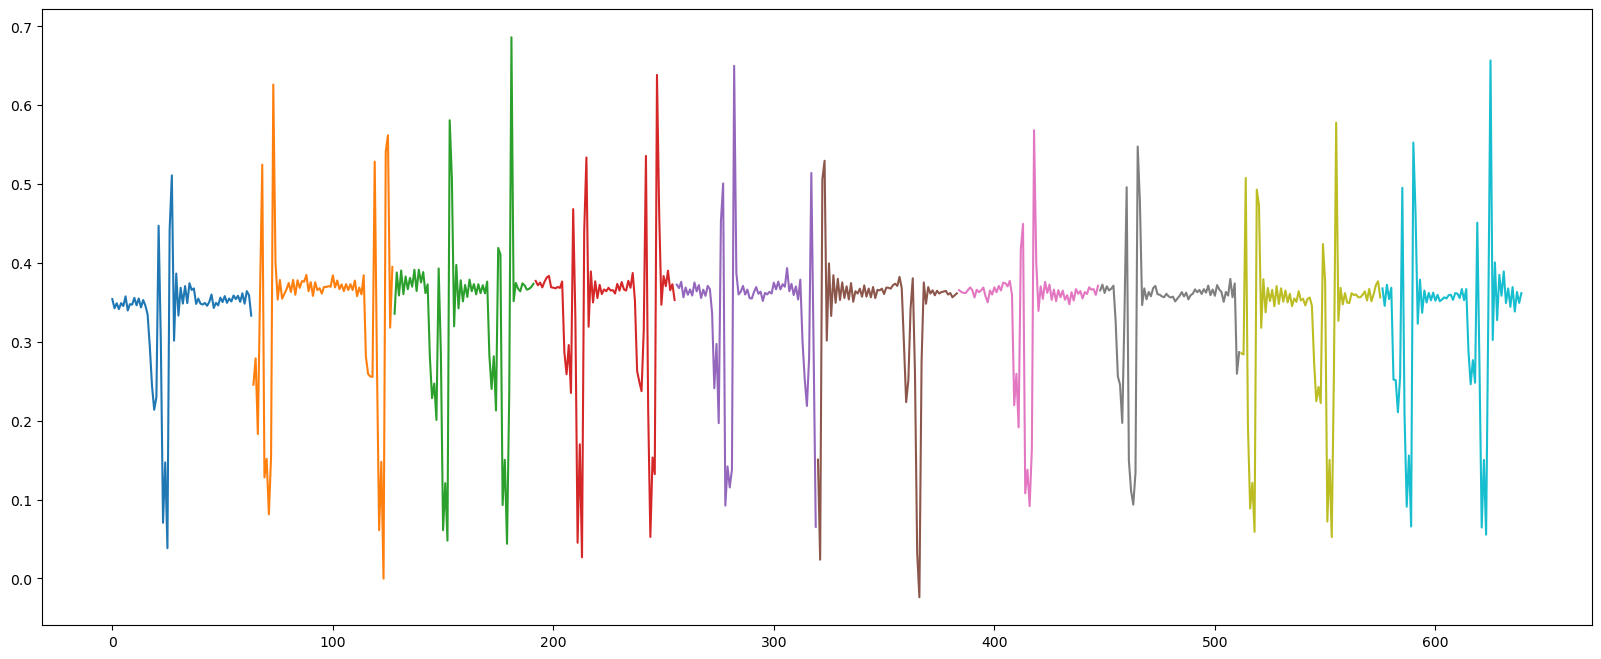

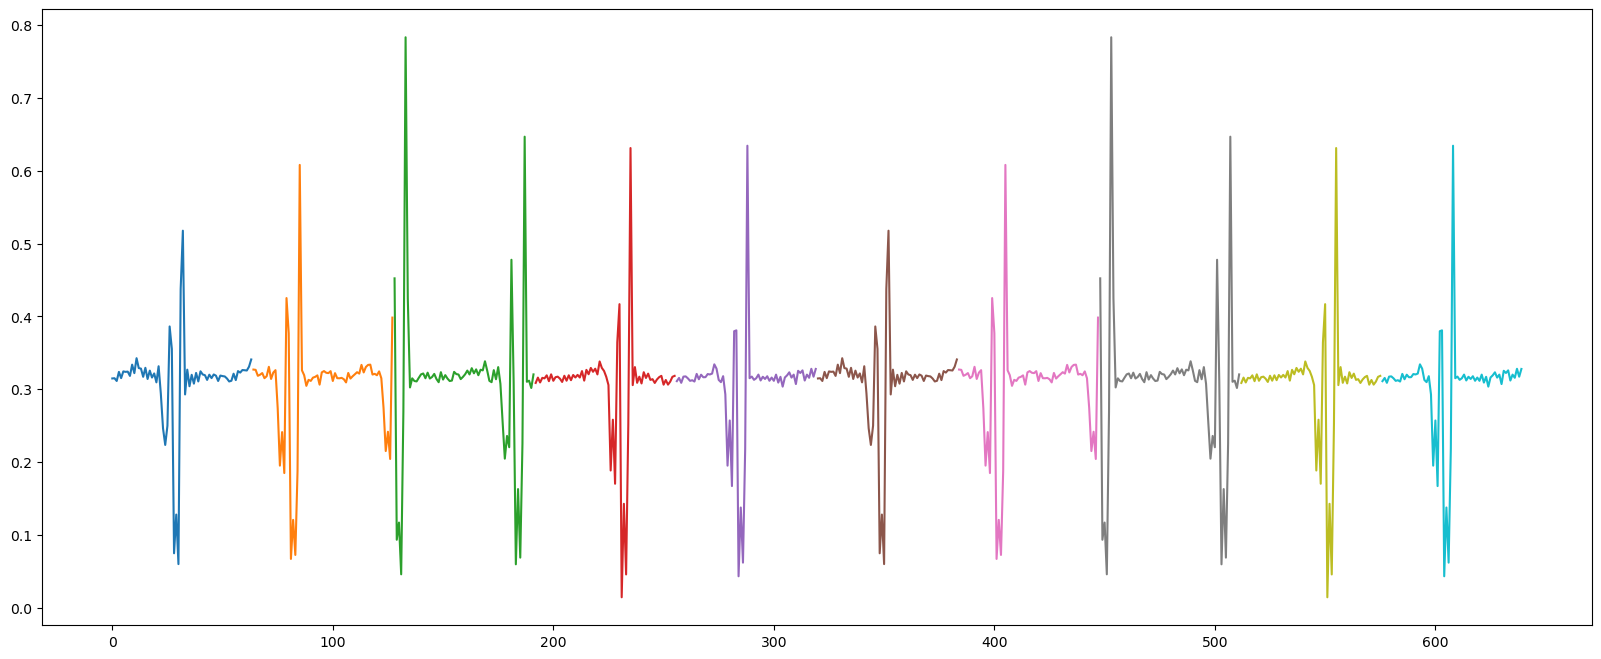

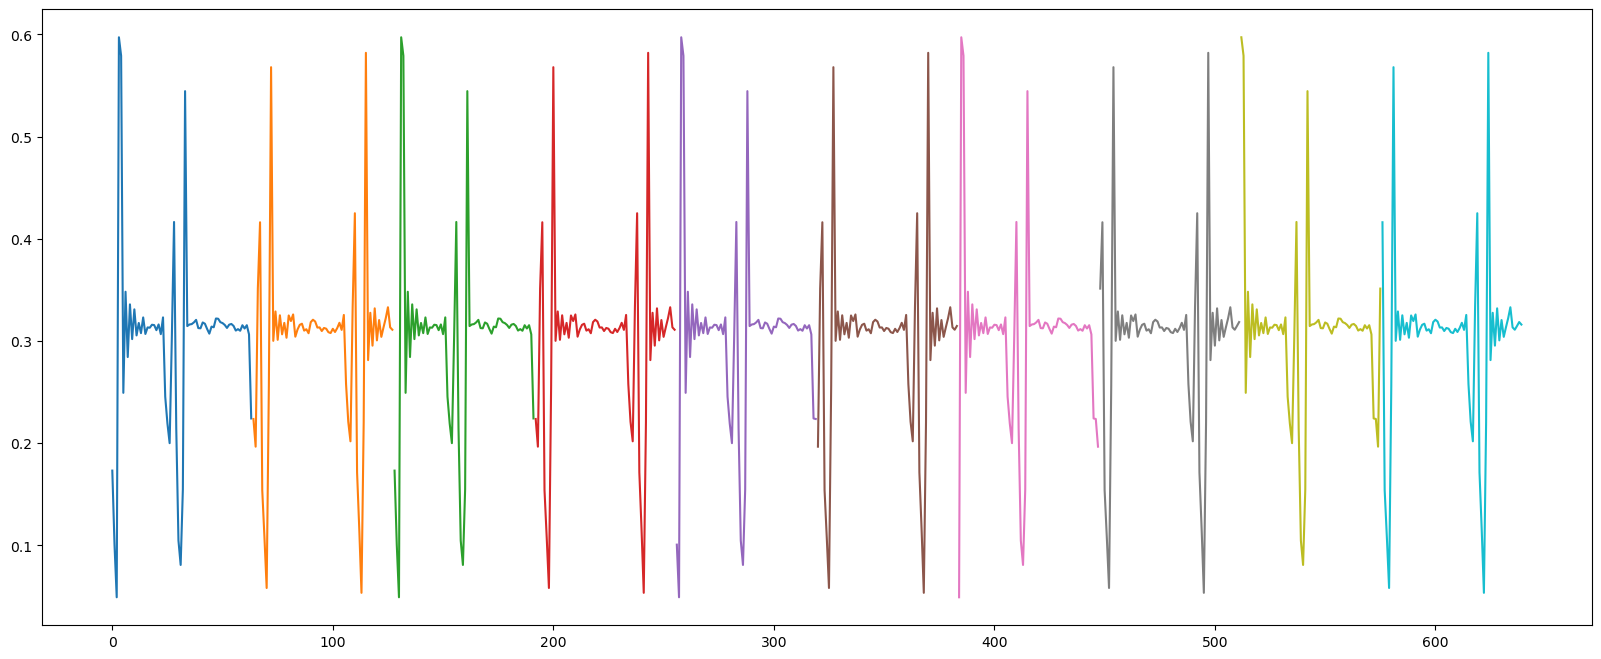

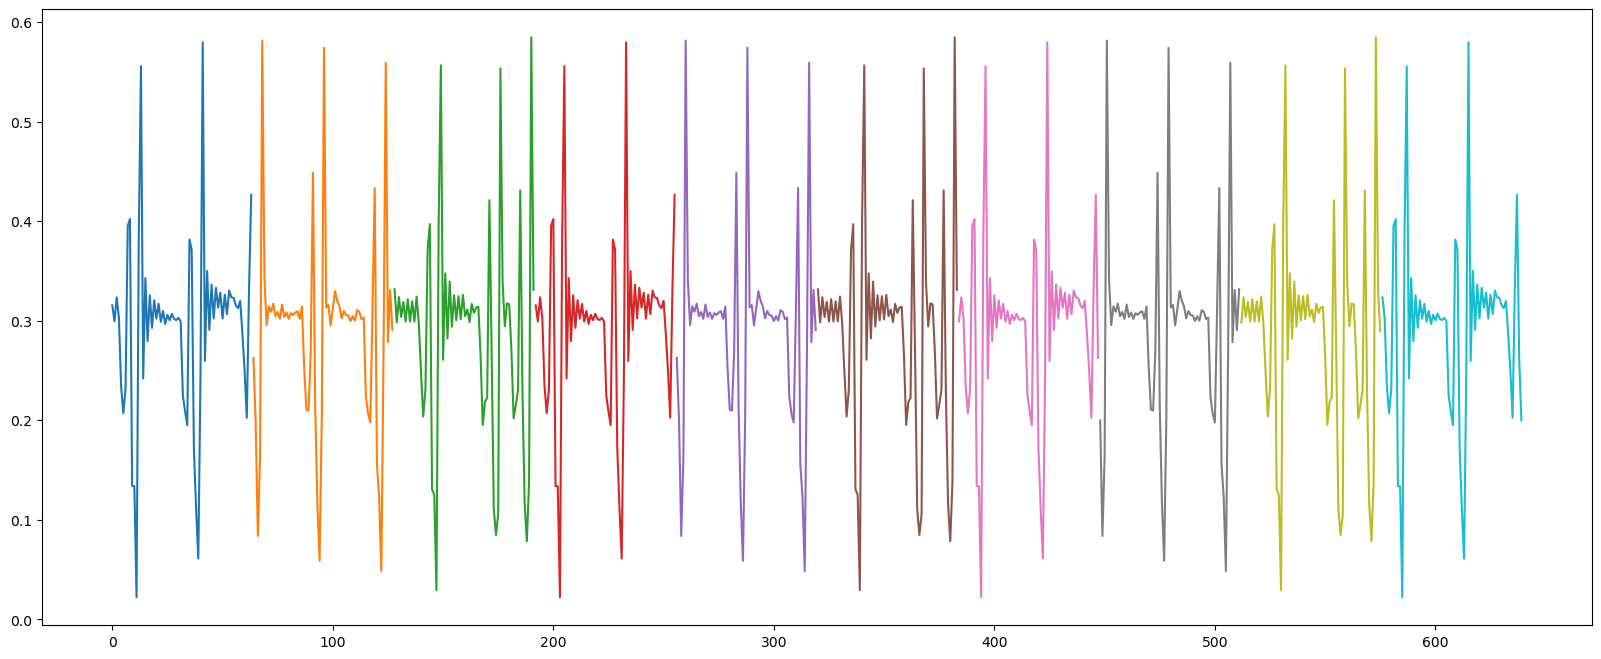

In [14]:
variable = 1

print("Variable:", name_list[ground_truth_variable[variable]])
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[0][window,:,variable])
plt.show()
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[1][window,:,variable])
plt.show()

for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[2][window,:,variable])
plt.show()
for window in range(10):
    x__=np.arange(window*input_window,(window+1)*input_window)
    plt.plot(x__,test_data_preprocessed_y[3][window,:,variable])
plt.show()

# Create Model 

In [15]:
batch_size = 64
model_dimension = 48
encoder_feed_forward = 128       
num_layers= 1
num_heads= 4        
encoder_dropout_rate =0.1
segment_sizes=16
segment_stride=4

transpose_cnn_kernal_size = segment_sizes


In [16]:
model = tm.EncoderTransformer(
    num_layers=num_layers,
    model_dimension=model_dimension,            
    num_heads=num_heads,
    encoder_feed_forward=encoder_feed_forward,           
    model_input_size =  input_window,      
    model_output_size = input_window,
    encoder_dropout_rate =encoder_dropout_rate ,
    segment_sizes=segment_sizes,
    segment_stride=segment_stride,
    transpose_cnn_for_rekonstruction=True,
    transpose_cnn_kernal_size=transpose_cnn_kernal_size,
    output_dim = y_train.shape[-1]
    
    )

#Learning rate schedule
steps_per_epoch = (len(x_train) // batch_size)
learning_rate = lrs.CosineDecayWithWarmup(steps_per_epoch*4,5e-4,steps_per_epoch*45)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98) 
model(x_train[:batch_size,:,:])
model.compile(
    loss=tf.keras.losses.MeanSquaredError(),
    optimizer=optimizer,
    metrics=tf.keras.losses.MeanSquaredError()
    )

model.summary()

stride 2
stride 2
Model: "encoder_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 segmentation_projektion (Se  multiple                 13200     
 gmentationProjektion)                                           
                                                                 
 encoder_layer (EncoderLayer  multiple                 50144     
 )                                                               
                                                                 
 dropout_1 (Dropout)         multiple                  0         
                                                                 
 feed_forward_with_sigmoid_a  (64, 16, 48)             12464     
 ctivation (Sequential)                                          
                                                                 
 conv1d_transpose (Conv1DTra  multiple                 2307      
 nspose)                     

# Train Model 

In [17]:
#Use early stopping to hit the optimum. 
cb = tf.keras.callbacks.EarlyStopping(
    monitor='val_mean_squared_error',
    mode='min',
    #After finishing training take the best weights
    restore_best_weights = True,  
    #Stopp traning after x epochs without improvement. 
    patience = 10,       
)

model_history = model.fit(
            x= x_train,
            y= y_train,   
            #validation_split=0.20,     
            validation_data = (x_valid, y_valid),
            steps_per_epoch= (x_train.shape[0]) // batch_size,
            batch_size=batch_size,
            epochs=50,
            shuffle=True,                
            callbacks=[cb]
            )

Epoch 1/50
390/390 [==============================] - 4s 6ms/step - loss: 0.0729 - mean_squared_error: 0.0729 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 2/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0035 - val_mean_squared_error: 0.0035
Epoch 3/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0035 - mean_squared_error: 0.0035 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 4/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0019 - mean_squared_error: 0.0019 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 6/50
390/390 [==============================] - 2s 5ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/50
390/390 [========

# Evaluation


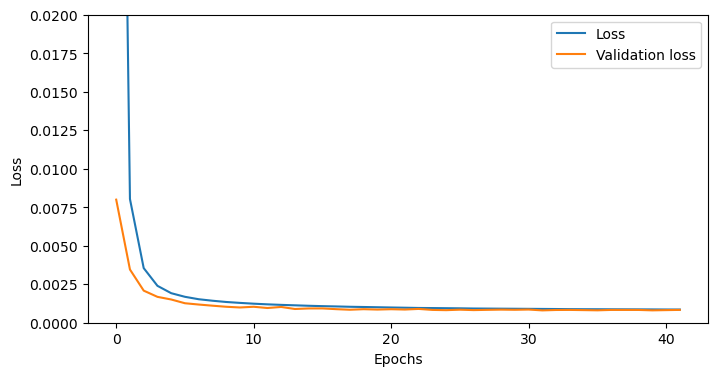

In [18]:
plt.rcParams['figure.figsize'] = [8, 4]

plt.plot(model_history.history['loss'], label='Loss')
plt.plot(model_history.history['val_loss'], label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.ylim((0,0.02))
plt.legend()
plt.show()

## Reconstruction Error

In [19]:
for variable in range(len(test_data_preprocessed_x)):
    print(all_test_data_names[variable])
    model.evaluate(test_data_preprocessed_x[variable], test_data_preprocessed_y[variable])


Normal
34/34 [==============================] - 0s 2ms/step - loss: 0.0018 - mean_squared_error: 0.0018
Drehtisch Widerstand
10/10 [==============================] - 0s 3ms/step - loss: 0.0177 - mean_squared_error: 0.0177
Drehtisch Blockiert
4/4 [==============================] - 0s 3ms/step - loss: 0.1366 - mean_squared_error: 0.1385
Drehtisch zu wenig widerstand
6/6 [==============================] - 0s 4ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Transportband Widerstand
5/5 [==============================] - 0s 5ms/step - loss: 0.0100 - mean_squared_error: 0.0101
Schleichender Fehler Rondel
25/25 [==============================] - 0s 2ms/step - loss: 0.0110 - mean_squared_error: 0.0115
Schleichender Fehler Förderband
25/25 [==============================] - 0s 2ms/step - loss: 0.0113 - mean_squared_error: 0.0118


# Reconstruction of normal test data

34/34 [==============================] - 0s 2ms/step
normal test Data
(1024, 3)
(960,)
Variable: Gesamtstrom


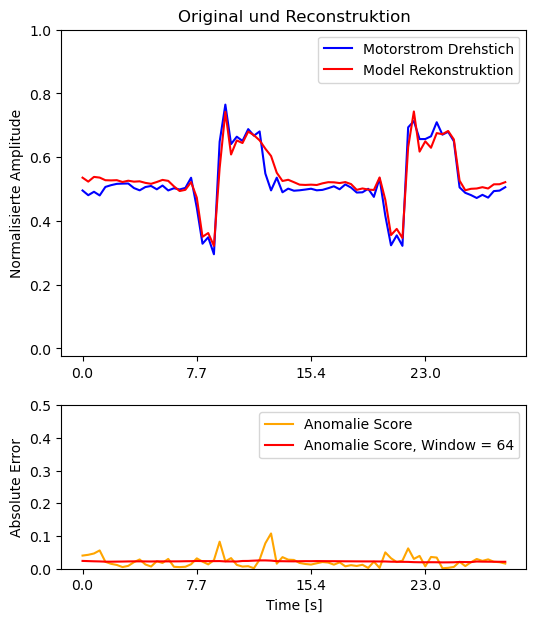

(960,)
Variable: Integerwert für den Motorstrom am Transportförderband


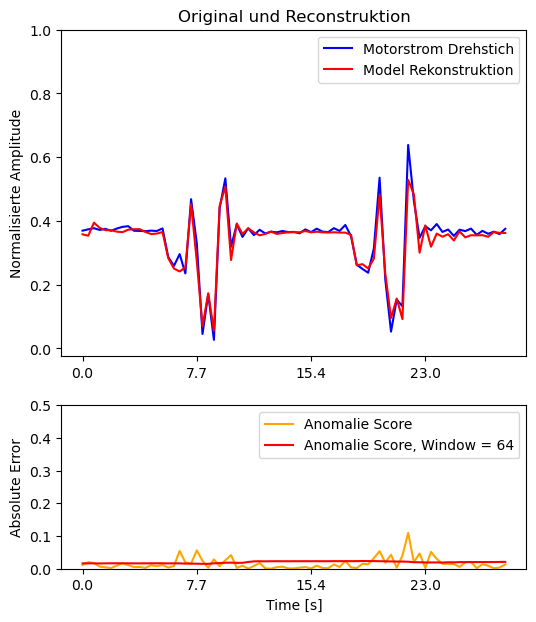

(960,)
Variable: Integerwert für den Motorstrom am Drehtisch


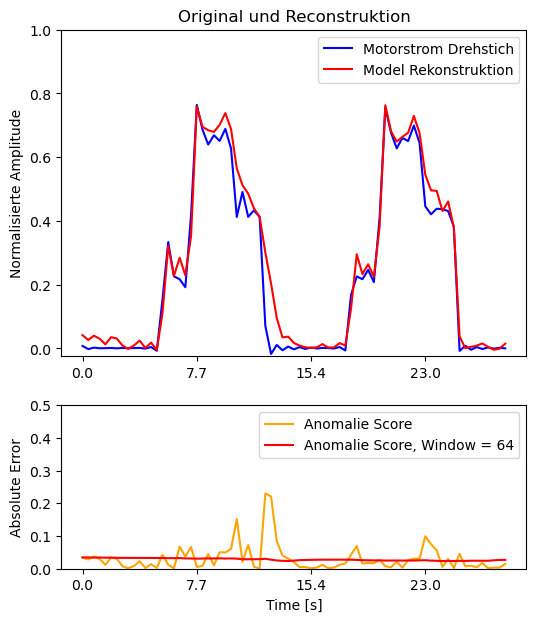

In [20]:
prediction_normal = model.predict(test_data_preprocessed_x[0])
y_normal = test_data_preprocessed_y[0]
prediction_reconstruct=pp.to_multiple_timeseries_reverse(prediction_normal, stride_of_window=1)
y_reconstruct=pp.to_multiple_timeseries_reverse(y_normal, stride_of_window=1)
plt.rcParams['figure.figsize'] = [6, 7]

range_l = 190
range_u = 265

print("normal test Data")

print(prediction_reconstruct.shape)
for variable in range(prediction_reconstruct.shape[-1]):

    mean=[]
    window=64
    for l in range(len(y_reconstruct)-window):
        mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,variable]-y_reconstruct[l:l+window,variable]))]

    mean = np.array(mean)
    print(mean.shape)


    fig, ax = plt.subplots(2, height_ratios=[2,1])
    print("Variable:", name_list[ground_truth_variable[variable]])
    ax[0].plot(y_reconstruct[range_l:range_u,variable], "b")
    ax[0].plot(prediction_reconstruct[range_l:range_u,variable], "r")
    ax[0].legend(["Motorstrom Drehstich", "Model Rekonstruktion"])#[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
    ax[0].set_ylabel("Normalisierte Amplitude")
    ax[0].title.set_text('Original und Reconstruktion')
    #fig.title("Drehstich ohne Anomalie")
    ax[0].set_ylim(-0.025, 1)
    time=np.arange(0,range_u-range_l,20)
    ax[0].set_xticks(time, np.round((time*384)/1000, 1))


    ax[1].plot(np.abs(y_reconstruct[range_l:range_u,variable]-prediction_reconstruct[range_l:range_u,variable]), "orange")
    ax[1].plot(mean[range_l:range_u], "r")
    
    ax[1].set_ylim(0, 0.5)
    ax[1].set_xticks(time, np.round((time*384)/1000, 1))

    ax[1].set_ylabel("Absolute Error")
    ax[1].set_xlabel("Time [s]")
    ax[1].legend(["Anomalie Score", "Anomalie Score, Window = 64"])
    
    plt.show()


## Reconstruction of anomalie test data

Plot one window of all variable of all anomalie classes

10/10 [==============================] - 0s 2ms/step
(256, 3)
(256, 3)
Anomlie: Drehtisch Widerstand
Variable: Gesamtstrom
(192,)


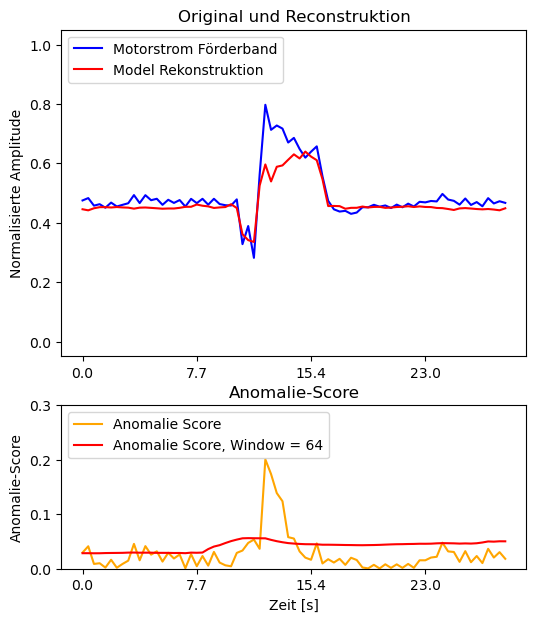

Variable: Integerwert für den Motorstrom am Transportförderband
(192,)


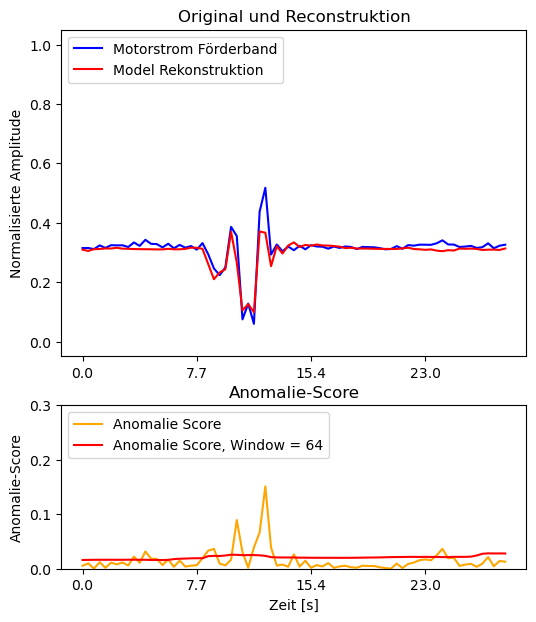

Variable: Integerwert für den Motorstrom am Drehtisch
(192,)


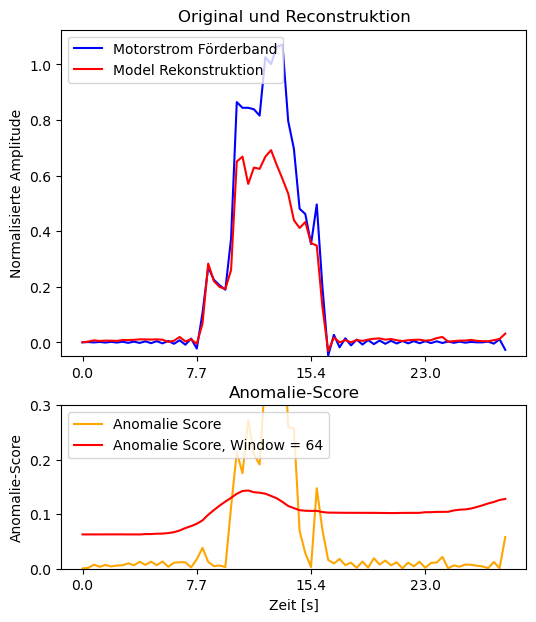

4/4 [==============================] - 0s 3ms/step
(64, 3)
(64, 3)
Anomlie: Drehtisch Blockiert
Variable: Gesamtstrom
(0,)


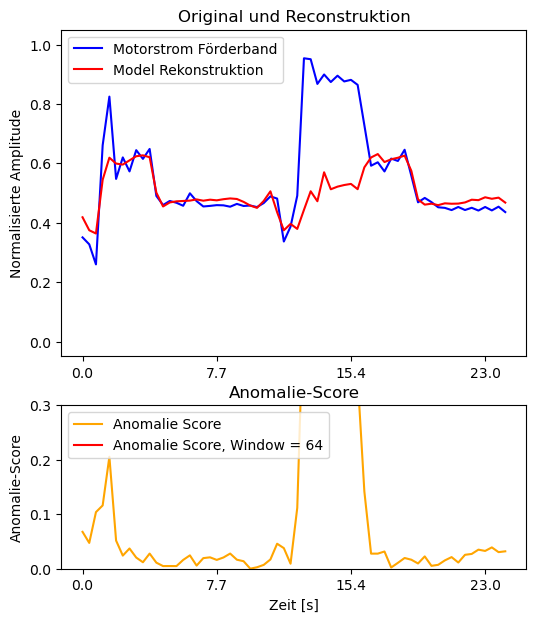

Variable: Integerwert für den Motorstrom am Transportförderband
(0,)


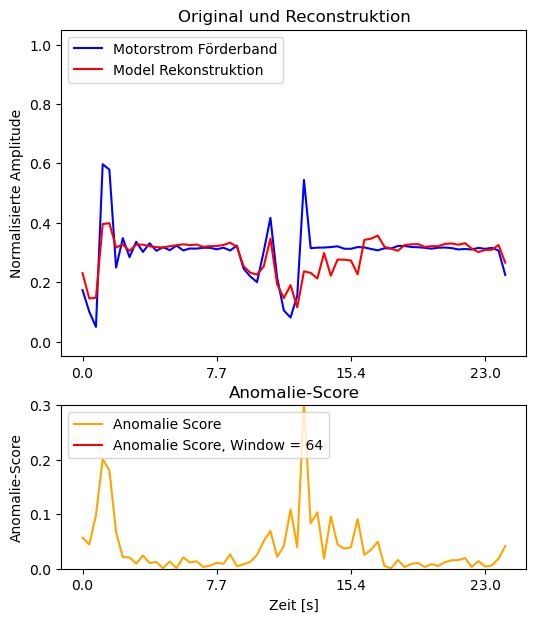

Variable: Integerwert für den Motorstrom am Drehtisch
(0,)


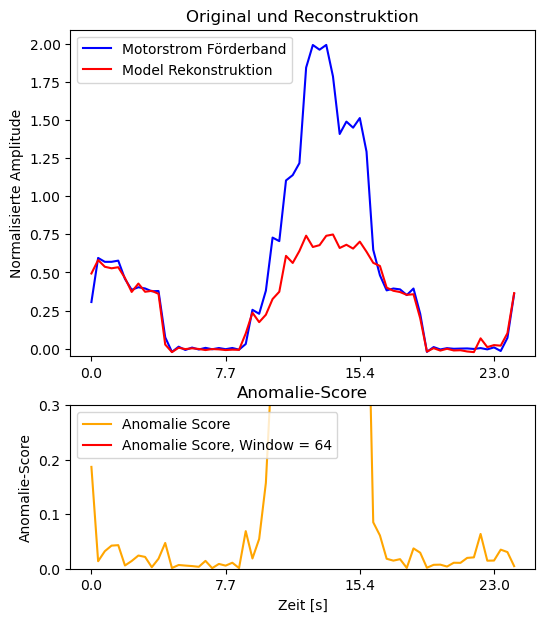

6/6 [==============================] - 0s 3ms/step
(128, 3)
(128, 3)
Anomlie: Drehtisch zu wenig widerstand
Variable: Gesamtstrom
(64,)


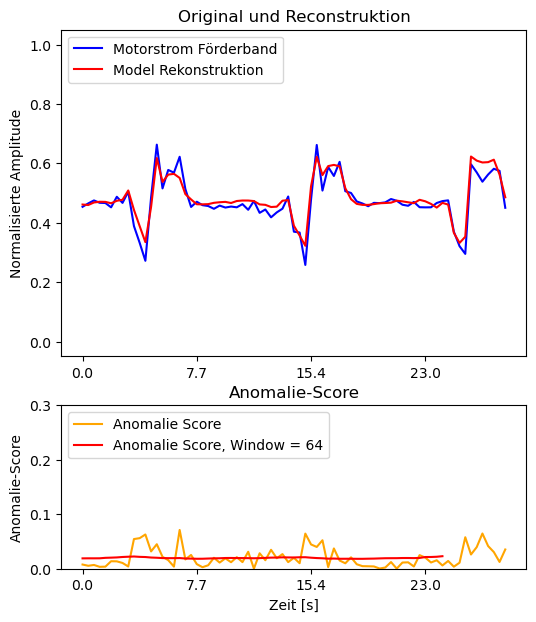

Variable: Integerwert für den Motorstrom am Transportförderband
(64,)


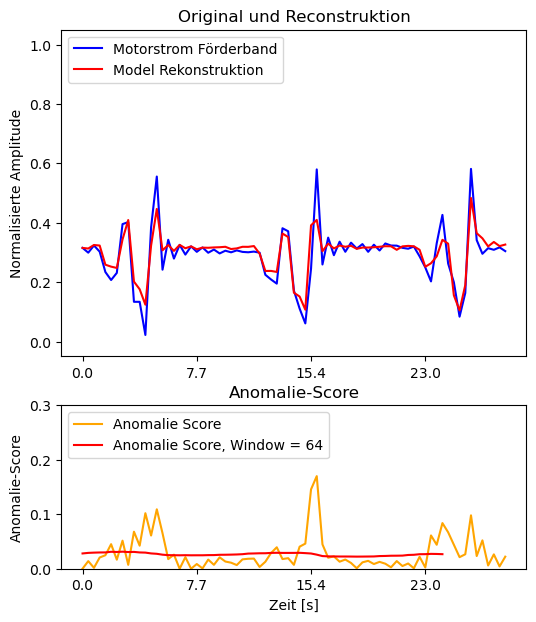

Variable: Integerwert für den Motorstrom am Drehtisch
(64,)


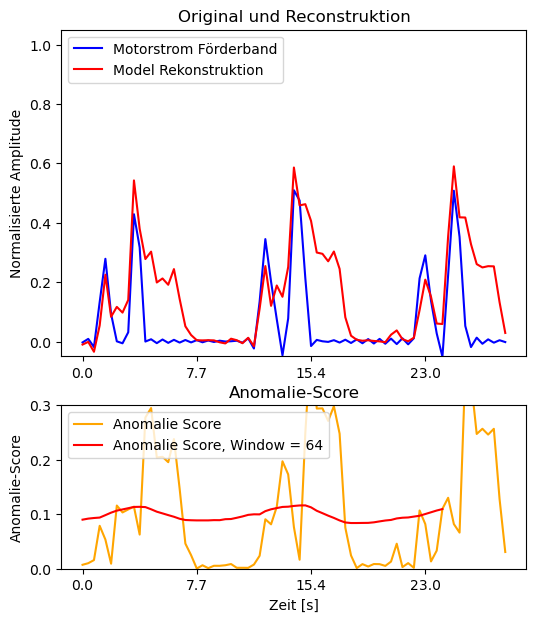

5/5 [==============================] - 0s 1ms/step
(128, 3)
(128, 3)
Anomlie: Transportband Widerstand
Variable: Gesamtstrom
(64,)


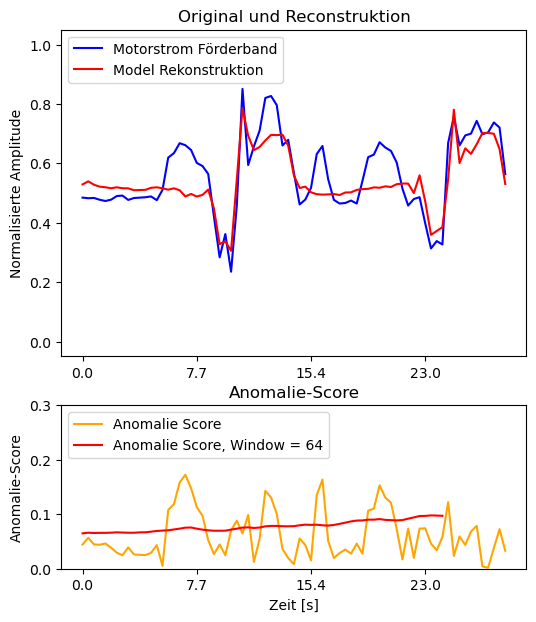

Variable: Integerwert für den Motorstrom am Transportförderband
(64,)


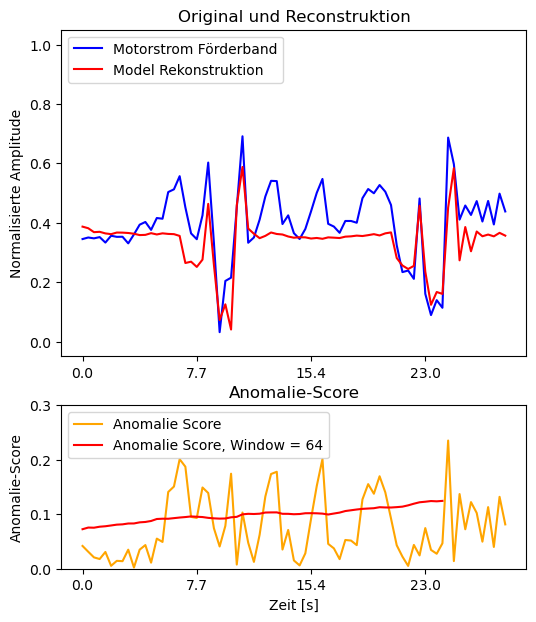

Variable: Integerwert für den Motorstrom am Drehtisch
(64,)


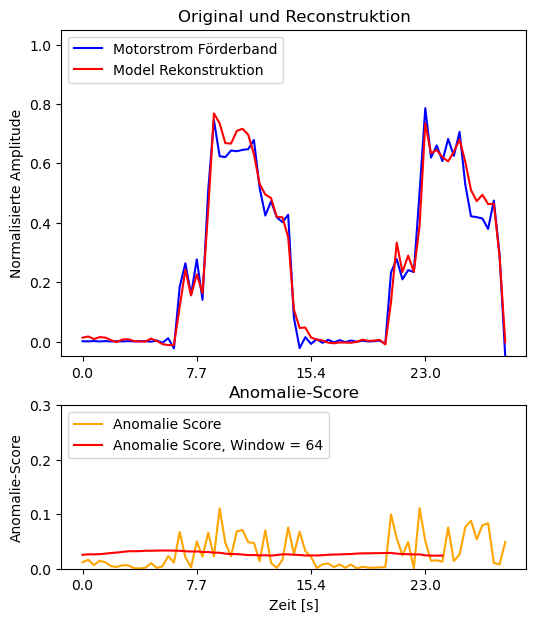

25/25 [==============================] - 0s 2ms/step
(768, 3)
(768, 3)
Anomlie: Schleichender Fehler Rondel
Variable: Gesamtstrom
(704,)


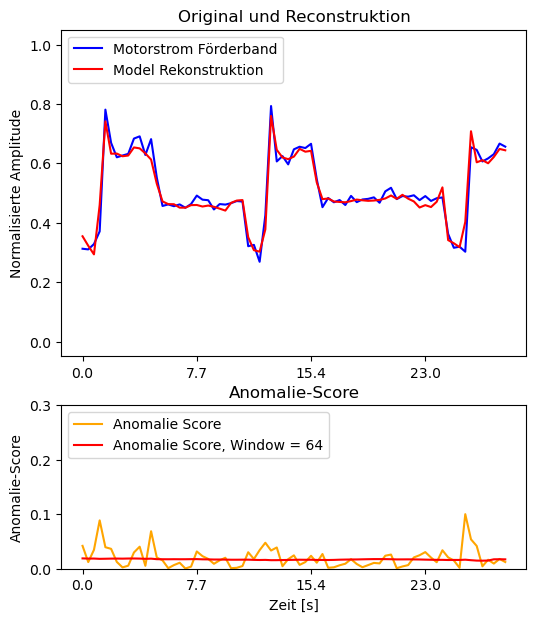

Variable: Integerwert für den Motorstrom am Transportförderband
(704,)


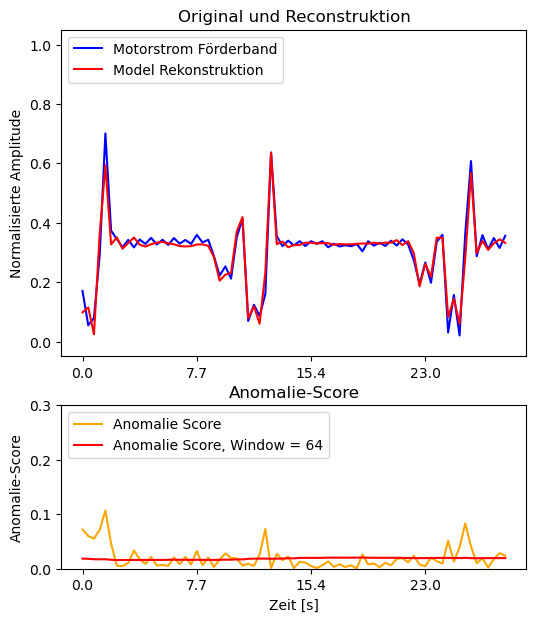

Variable: Integerwert für den Motorstrom am Drehtisch
(704,)


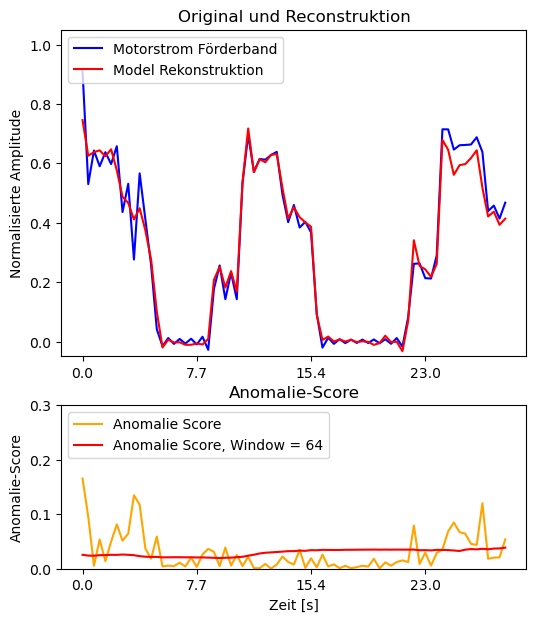

25/25 [==============================] - 0s 3ms/step
(768, 3)
(768, 3)
Anomlie: Schleichender Fehler Förderband
Variable: Gesamtstrom
(704,)


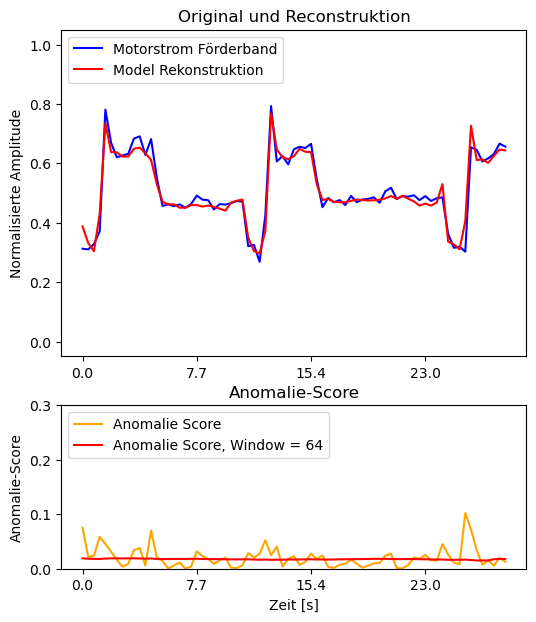

Variable: Integerwert für den Motorstrom am Transportförderband
(704,)


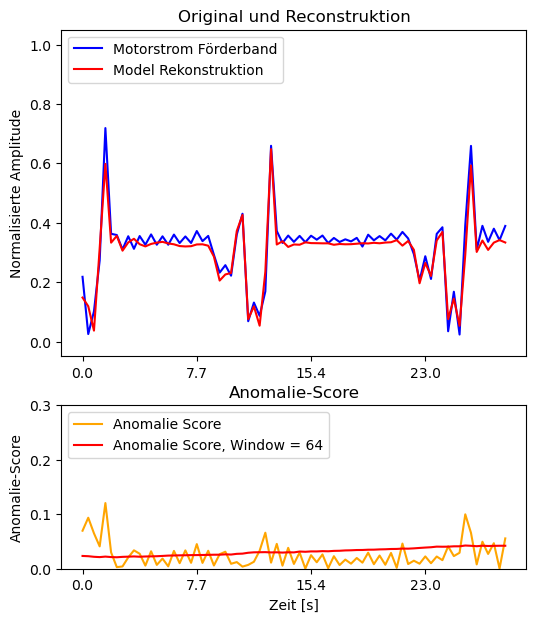

Variable: Integerwert für den Motorstrom am Drehtisch
(704,)


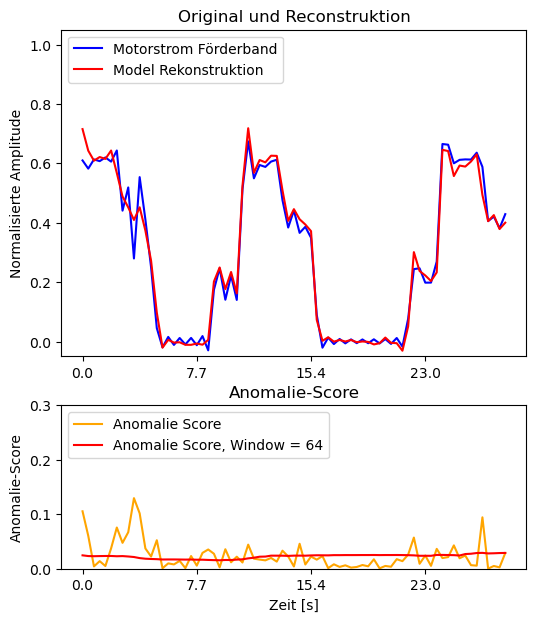

In [21]:
plt.rcParams['figure.figsize'] = [6, 7]
test_data_anaomlie_prediction=[]
test_data_anomalie_y=[]

range_l = 0#170#250#0#0#250
range_u = 75#245#480#150#150#480

for variable in range(1,len(test_data_preprocessed_x)):
    
    test_data_anaomlie_prediction += [model.predict(test_data_preprocessed_x[variable])]
    test_data_anomalie_y += [test_data_preprocessed_y[variable]]

    prediction_reconstruct=pp.to_multiple_timeseries_reverse(test_data_anaomlie_prediction[variable-1], stride_of_window=1)
    y_reconstruct=pp.to_multiple_timeseries_reverse(test_data_anomalie_y[variable-1], stride_of_window=1)
    print(y_reconstruct.shape)

    mean=[]
    
   

    print(prediction_reconstruct.shape)
    print("Anomlie:", all_test_data_names[variable])
    for j in range(prediction_reconstruct.shape[-1]):
        print("Variable:", name_list[ground_truth_variable[j]])


        mean=[]
        window=64
        for l in range(len(y_reconstruct)-window):
            mean += [np.mean(np.abs(prediction_reconstruct[l:l+window,j]-y_reconstruct[l:l+window,j]))]

        mean = np.array(mean)
        print(mean.shape)


        #[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
        '''
        plt.ylabel("Normalisierte Amplitude")
        plt.xlabel("Zeit [s]")
        plt.title("Drehtisch Widerstand")
        plt.plot(y_reconstruct[range_l:range_u,j], "b")
        plt.ylim([-0.05, np.max(np.append(1, np.max(y_reconstruct[range_l:range_u,j]))*1.05 )])
        time=np.arange(0,range_u-range_l,20)
        plt.xticks(time, np.round((time*384)/1000, 1))
        plt.legend(["Motorstrom Drehtisch"])
        plt.show()
        '''

        fig, ax = plt.subplots(2, height_ratios=[2,1])
   
        ax[0].set_ylim([-0.05, np.max(np.append(1, np.max(y_reconstruct[range_l:range_u,j]))*1.05 )])
        ax[0].plot(y_reconstruct[range_l:range_u,j], "b")
        ax[0].plot(prediction_reconstruct[range_l:range_u,j], "r")
        #ax[0].ylabel("Amplitude")
        #ax[0].xlabel("Zeit")
        #ax[0].title("Gesamtstrom mit Anomalie")
        #ax[0].ylim(0, 1)
        #ax[0].legend([name_list[ground_truth_variable[j]], str(name_list[ground_truth_variable[j]]) + " Prediction"])
        ax[0].set_xticks(time, np.round((time*384)/1000, 1))
        ax[0].title.set_text('Original und Reconstruktion')
        ax[0].legend(["Motorstrom Förderband", "Model Rekonstruktion"], loc="upper left")#[name_list[ground_truth_variable[i]], str(name_list[ground_truth_variable[i]]) + " Prediction"])
        time=np.arange(0,range_u-range_l,20)
        #ax[0].xticks(time, np.round((time*384)/1000, 1))
        plt.xlabel("Zeit [s]")
        ax[0].set_ylabel("Normalisierte Amplitude")       





        ax[1].plot(np.abs(y_reconstruct[range_l:range_u,j]-prediction_reconstruct[range_l:range_u,j]), "orange")
        ax[1].plot(mean[range_l:range_u], "r")
        ax[1].title.set_text('Anomalie-Score')
        ax[1].set_ylabel("Anomalie-Score")     
        ax[1].legend(["Anomalie Score", "Anomalie Score, Window = 64"], loc="upper left")
        ax[1].set_ylim(0,0.3)
        #ax[1].plot(mean[range_l:range_u], "r")
        
        #ax[1].plot(np.ones(len(mean[range_l:range_u])) * 0.1, "b")

        #ax[1].ylim(0, 0.5)
        #ax[1].xticks(time, np.round((time*384)/1000, 1))

        #ax[1].ylabel("Absoluter Fehler")
        #ax[1].xlabel("Zeit")
        #ax[1].legend(["Anomalie-Score", "Anomalie-Score, Window = 16", "Schwellwert"])
        #ax[1].title("Durchschnittlicher Anomalie-Score über Variablen")
        time=np.arange(0,range_u-range_l,20)
        plt.xticks(time, np.round((time*384)/1000, 1))
        plt.show()
    

In [22]:
#Input dim: (sample, timeseries window) or (sample, timeseries window, variable) 
def calculate_mse(prediction, y, add_mse_fromEach_variable=False): 
    mse=[]
    print(prediction.shape, y.shape)

    if len(prediction.shape)==2:
        mse=[]
        for i in range(len(prediction)):
            mse += [np.mean( np.square(prediction[i]-y[i]))]
    elif len(prediction.shape)==3:
        for sample in range(prediction.shape[0]):
            tmp=[]
            for variable in range(y.shape[-1]):
                tmp += [np.mean( np.square(prediction[sample,:,variable]-y[sample,:,variable]))]
            mse += [tmp]
        if add_mse_fromEach_variable:
            added_mse=[]
            for i in range(len(mse)):
                added_mse += [np.mean(mse[i])]
            
            mse=added_mse

    else:
        raise Exception("Dimension error")

    return np.array(mse)

In [23]:
mse_normal = calculate_mse(prediction_normal, test_data_preprocessed_y[0])

(1061, 64, 3) (1061, 64, 3)


In [24]:
mse_anomlie=[]
for variable in range(len(test_data_anaomlie_prediction)):
    mse_anomlie += [calculate_mse(test_data_anaomlie_prediction[variable], test_data_anomalie_y[variable])]


(316, 64, 3) (316, 64, 3)
(112, 64, 3) (112, 64, 3)
(163, 64, 3) (163, 64, 3)
(135, 64, 3) (135, 64, 3)
(771, 64, 3) (771, 64, 3)
(771, 64, 3) (771, 64, 3)


#  Precision-Recall and Histogram of Anomalie-Score for each Variable

Variable: Gesamtstrom
max 0.01047761645168066
max mse values normal: 0.0043345694


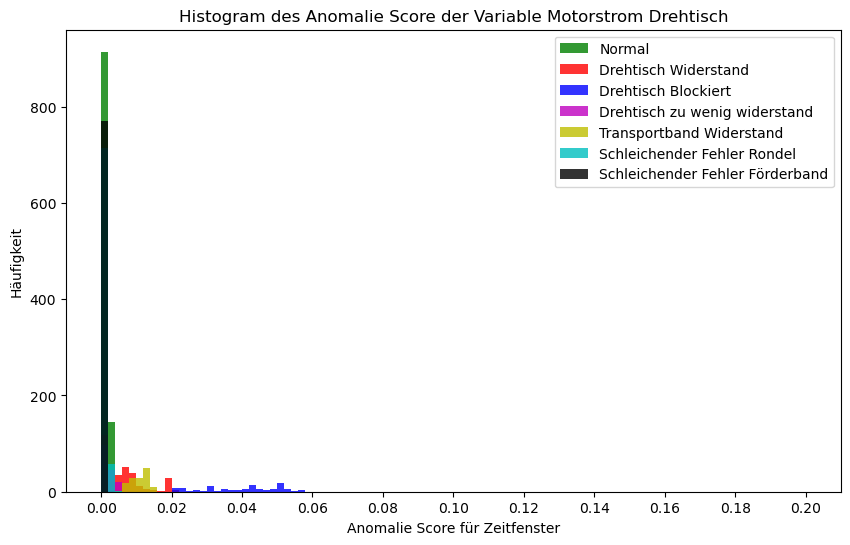

AUCPR: 0.7292033962052412


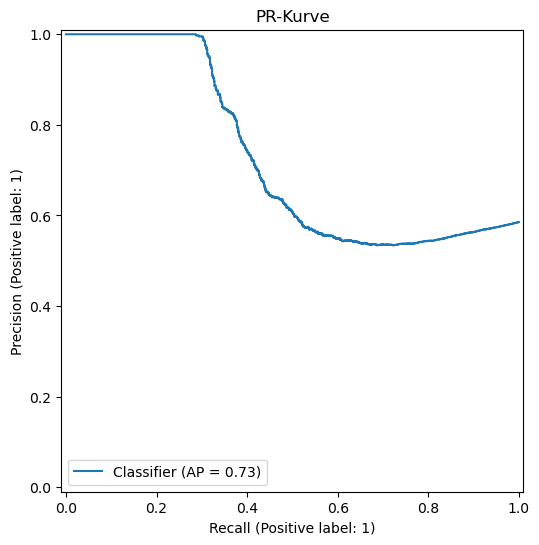

Variable: Integerwert für den Motorstrom am Transportförderband
max 0.01047761645168066
max mse values normal: 0.0070465235


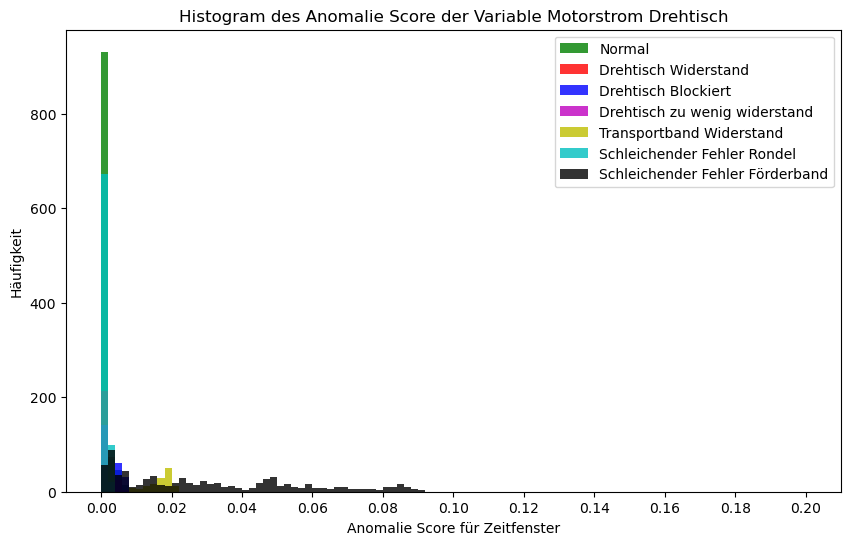

AUCPR: 0.7112955918381334


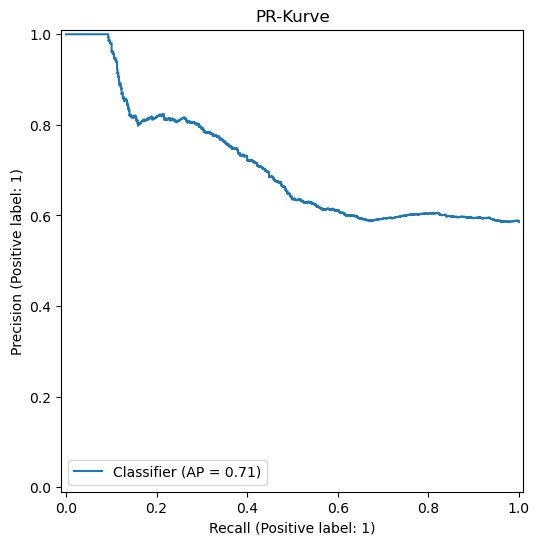

Variable: Integerwert für den Motorstrom am Drehtisch
max 0.01047761645168066
max mse values normal: 0.0048510293


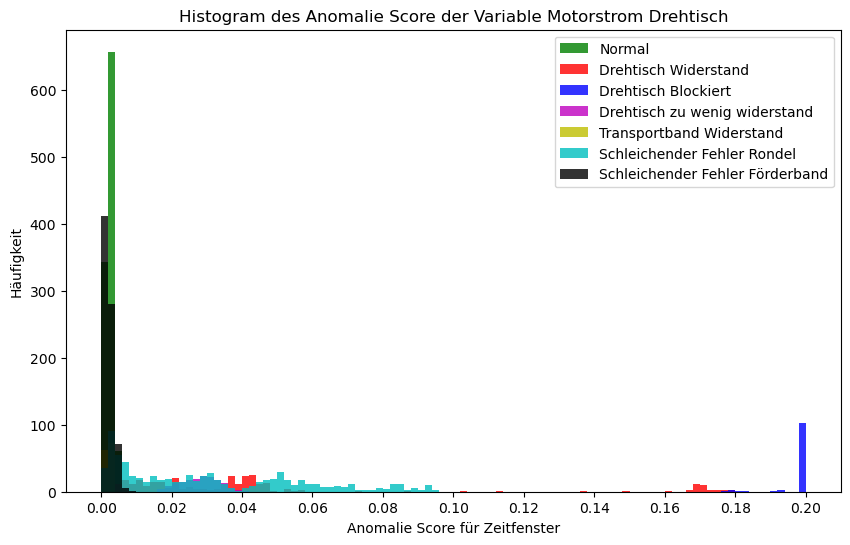

AUCPR: 0.9498325920431503


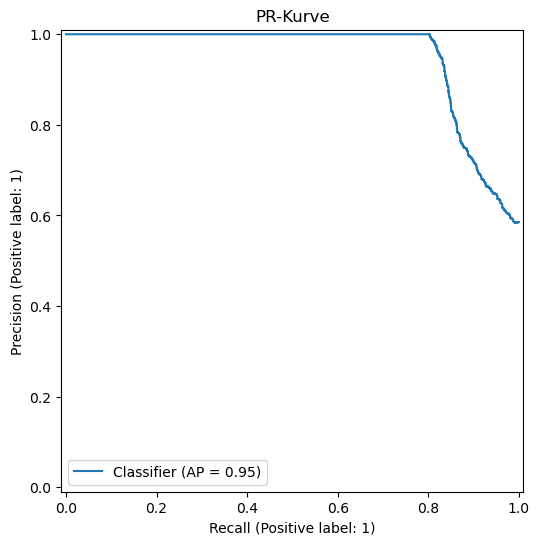

In [25]:
#MSE of all predictions
list_of_thresholds=[]

for variable in range(y_train.shape[-1]):


    density=False
    colors=["r","b", "m", "y", "c", "black"]
    plt.rcParams['figure.figsize'] = [10, 6]

    print("Variable:", name_list[ground_truth_variable[variable]])


    array= mse_normal[:,:].flatten()
    max_= np.std(array)*10
    print("max",max_)
    plot_range=[0.00,0.2]


    plt.hist(mse_normal[:,variable],bins = 100,density= density, range=plot_range,color="g",alpha=0.8,log=False)
    list_of_thresholds+=[float(max(mse_normal[:,variable]))]
    print("max mse values normal:",max(mse_normal[:,variable]))


    for j in range(len(mse_anomlie)):        

        if plot_range != None: 
            for g in range(len(mse_anomlie[j][:,variable])):
                if mse_anomlie[j][g,variable] > plot_range[-1]:
                    mse_anomlie[j][g,variable] = plot_range[-1]

        
        plt.hist(mse_anomlie[j][:,variable],bins = 100,density= density, range=plot_range,alpha=0.8,log=False, color=colors[j])



    plt.legend(all_test_data_names)
    plt.locator_params(axis='x', nbins=20)
    plt.xlabel("Anomalie Score für Zeitfenster")
    plt.ylabel("Häufigkeit")
    plt.title("Histogram des Anomalie Score der Variable Motorstrom Drehtisch")

    plt.show()


    mse_normal_mean=mse_normal[:,variable]

    mse_anomal_sum=np.array(mse_anomlie[0][:,variable])
    for j in range(1,len(mse_anomlie)-1):
        mse_anomal_sum=np.append(mse_anomal_sum, mse_anomlie[j][:,variable], axis=-1)

    label_n = np.zeros(len(mse_normal_mean))
    label_a = np.ones(len(mse_anomal_sum))
    y_score=np.append(mse_normal_mean,mse_anomal_sum)
    y_test=np.append(label_n,label_a)

    precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_score)
    auc_precision_recall = sklearn.metrics.auc(recall, precision)
    print("AUCPR:",auc_precision_recall)
    sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_score)
    plt.title("PR-Kurve")
    plt.show()



# Precision-Recall and Histogram of Anomalie-Score

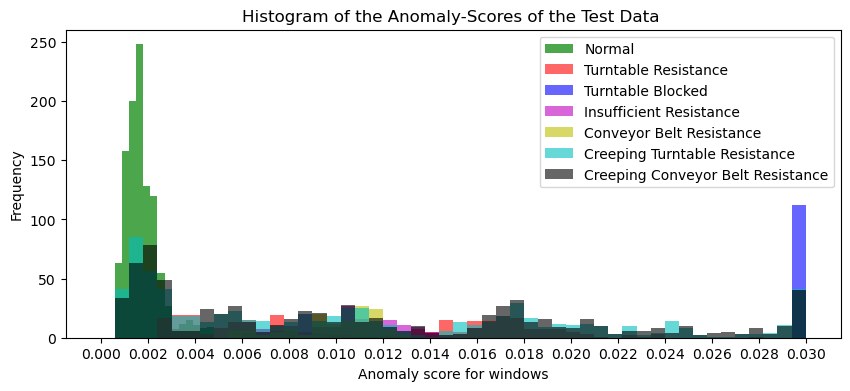

AUCPR: 0.9644146198722036


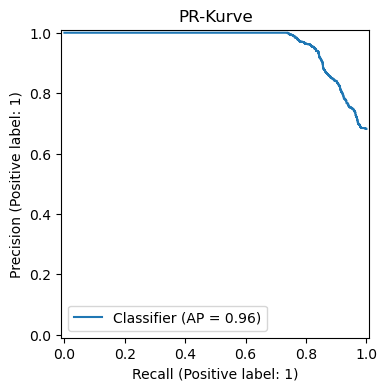

In [26]:
plot_range=[0.00, 0.03]
plt.rcParams['figure.figsize'] = [10, 4]
density=False
colors=["r","b", "m", "y", "c", "black"]

plt.hist(np.mean(mse_normal[:,:],axis=-1),bins = 100,density= density, range=plot_range,color="g",alpha=0.7,log=False, )

for j in range(len(mse_anomlie)):
     mse_mean_over_variablen=np.mean(mse_anomlie[j][:,:],axis=-1)

     for variable in range(len(mse_mean_over_variablen)):
          if mse_mean_over_variablen[variable] > plot_range[-1]:
               mse_mean_over_variablen[variable] = plot_range[-1]

     plt.hist(mse_mean_over_variablen,bins = 50,density= density, range=plot_range,alpha=0.6,log=False, color=colors[j])



plt.legend( ['Normal', 'Turntable Resistance', 'Turntable Blocked', 'Insufficient Resistance', 'Conveyor Belt Resistance', 'Creeping Turntable Resistance', 'Creeping Conveyor Belt Resistance'])
plt.locator_params(axis='x', nbins=20)
plt.ylabel("Frequency")
plt.xlabel("Anomaly score for windows")
plt.title("Histogram of the Anomaly-Scores of the Test Data ")
plt.show()
mse_normal_mean=np.mean(mse_normal[:,:], axis=-1)

mse_anomal_sum=np.array(np.mean(mse_anomlie[0][:,:], axis=-1))
for j in range(1,len(mse_anomlie)):
     mse_anomal_sum=np.append(mse_anomal_sum, np.mean(mse_anomlie[j][:,:], axis=-1), axis=-1)

label_n = np.zeros(len(mse_normal_mean))
label_a = np.ones(len(mse_anomal_sum))
y_score=np.append(mse_normal_mean,mse_anomal_sum)
y_test=np.append(label_n,label_a)


precision, recall, thresholds = sklearn.metrics.precision_recall_curve(y_test, y_score)
auc_precision_recall = sklearn.metrics.auc(recall, precision)
print("AUCPR:",auc_precision_recall)
sklearn.metrics.PrecisionRecallDisplay.from_predictions(y_test, y_score)
#plt.xlabel("Precsision TP/(TP+FP)")
#plt.ylabel("Recall TP/(TP+FN)")    
plt.title("PR-Kurve")
plt.show()


0.0070465235
als anomaly erkannt 563
als normal erkannt 208


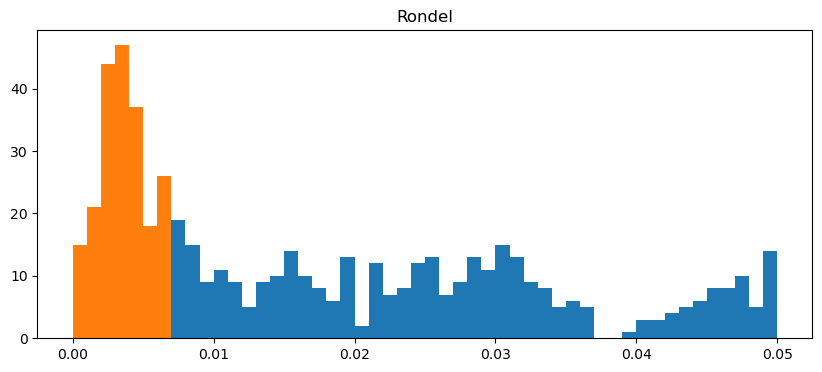

als anomaly erkannt 573
als normal erkannt 198


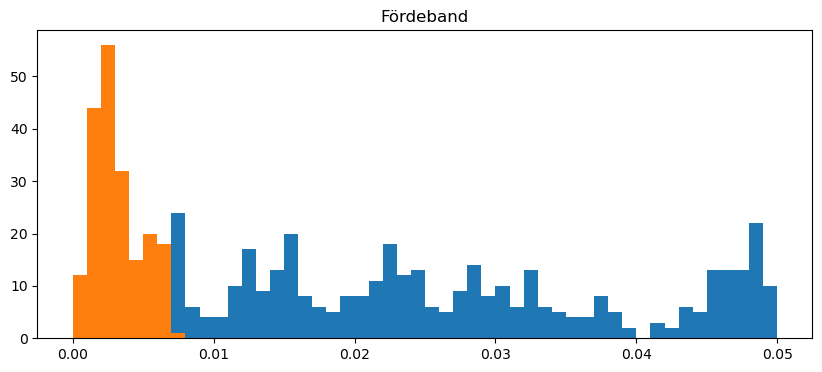

In [27]:
threshold = mse_normal.max()
print(threshold)
mse_schleichend_rondel = mse_anomlie[-2][:,2]#Rondel Strom
mse_schleichend_foerder = mse_anomlie[-1][:,1]# Transportband Strom

mse_schleichend_ano_rondel = mse_schleichend_rondel[mse_schleichend_rondel>threshold]
mse_schleichend_nor_rondel = mse_schleichend_rondel[mse_schleichend_rondel<=threshold]

mse_schleichend_ano_foeder = mse_schleichend_foerder[mse_schleichend_foerder>threshold]
mse_schleichend_nor_foeder = mse_schleichend_foerder[mse_schleichend_foerder<=threshold]





print("als anomaly erkannt", len(mse_schleichend_ano_rondel))
print("als normal erkannt", len(mse_schleichend_nor_rondel))

plt.hist(mse_schleichend_ano_rondel,bins = 50, range=[0,0.05])
plt.hist(mse_schleichend_nor_rondel,bins = 50, range=[0,0.05])
plt.title("Rondel")
plt.show()


print("als anomaly erkannt", len(mse_schleichend_ano_foeder))
print("als normal erkannt", len(mse_schleichend_nor_foeder))

plt.title("Fördeband")
plt.hist(mse_schleichend_ano_foeder,bins = 50, range=[0,0.05])
plt.hist(mse_schleichend_nor_foeder,bins = 50, range=[0,0.05])
plt.show()

# Attention Score Visualization 

1 Gesamtstrom,
11 Integerwert für den Motorstrom am Transportförderband,
13 Integerwert für den Motorstrom am Drehtisch,

fake_labels = np.random.randint( 0, 1, size=len(test_data_preprocessed_x[0])  ) 

model.visualize_attention_score_within_timeseries(test_data_preprocessed_x[0], tf.one_hot( fake_labels, 1   ) , number_of_samples_to_plot_from_each_class = 5, x_test_variable_to_plot=1) #1 11 13

# Dimsnsions Reduction

In [28]:
_,_,feature_vector_test_anormal_Resistance = model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[1])
_,_,feature_vector_test_anormal_Blockage = model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[2])
_,_,feature_vector_test_anormal_no_resistance =  model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[3])
_,_,feature_vector_test_anormal_res_conv_belt =  model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[4])
_,_,feature_vector_test_anormal_Resistance_schleichend =  model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[5])
_,_,feature_vector_test_anormal_res_conv_belt_schleichend =  model.predict_return_attention_scores_and_feature_vectore(test_data_preprocessed_x[6])


#feature_vector_test_anormal_Resistance=feature_vector_test_anormal_Resistance[:,0:1,:]
shape=feature_vector_test_anormal_Resistance.shape
feature_vector_test_anormal_Resistance=np.reshape(feature_vector_test_anormal_Resistance, newshape=(shape[0], shape[1]*shape[2]))

#feature_vector_test_anormal_Blockage=feature_vector_test_anormal_Blockage[:,0:1,:]
shape=feature_vector_test_anormal_Blockage.shape
feature_vector_test_anormal_Blockage=np.reshape(feature_vector_test_anormal_Blockage, newshape=(shape[0], shape[1]*shape[2]))

#feature_vector_test_anormal_no_resistance=feature_vector_test_anormal_no_resistance[:,0:1,:]
shape=feature_vector_test_anormal_no_resistance.shape
feature_vector_test_anormal_no_resistance=np.reshape(feature_vector_test_anormal_no_resistance, newshape=(shape[0], shape[1]*shape[2]))

#feature_vector_test_anormal_res_conv_belt=feature_vector_test_anormal_res_conv_belt[:,0:1,:]
shape=feature_vector_test_anormal_res_conv_belt.shape
feature_vector_test_anormal_res_conv_belt=np.reshape(feature_vector_test_anormal_res_conv_belt, newshape=(shape[0], shape[1]*shape[2]))

#feature_vector_test_anormal_Resistance_schleichend=feature_vector_test_anormal_Resistance_schleichend[:,0:1,:]
shape=feature_vector_test_anormal_Resistance_schleichend.shape
feature_vector_test_anormal_Resistance_schleichend=np.reshape(feature_vector_test_anormal_Resistance_schleichend, newshape=(shape[0], shape[1]*shape[2]))

shape=feature_vector_test_anormal_res_conv_belt_schleichend.shape
feature_vector_test_anormal_res_conv_belt_schleichend=np.reshape(feature_vector_test_anormal_res_conv_belt_schleichend, newshape=(shape[0], shape[1]*shape[2]))



print(feature_vector_test_anormal_res_conv_belt.shape)

Sample: 0
Sample: 16
Sample: 32
Sample: 48
Sample: 64
Sample: 80
Sample: 96
Sample: 112
Sample: 128
Sample: 144
Sample: 160
Sample: 176
Sample: 192
Sample: 208
Sample: 224
Sample: 240
Sample: 256
Sample: 272
Sample: 288
Sample: 0
Sample: 16
Sample: 32
Sample: 48
Sample: 64
Sample: 80
Sample: 96
Sample: 0
Sample: 16
Sample: 32
Sample: 48
Sample: 64
Sample: 80
Sample: 96
Sample: 112
Sample: 128
Sample: 144
Sample: 0
Sample: 16
Sample: 32
Sample: 48
Sample: 64
Sample: 80
Sample: 96
Sample: 112
Sample: 0
Sample: 16
Sample: 32
Sample: 48
Sample: 64
Sample: 80
Sample: 96
Sample: 112
Sample: 128
Sample: 144
Sample: 160
Sample: 176
Sample: 192
Sample: 208
Sample: 224
Sample: 240
Sample: 256
Sample: 272
Sample: 288
Sample: 304
Sample: 320
Sample: 336
Sample: 352
Sample: 368
Sample: 384
Sample: 400
Sample: 416
Sample: 432
Sample: 448
Sample: 464
Sample: 480
Sample: 496
Sample: 512
Sample: 528
Sample: 544
Sample: 560
Sample: 576
Sample: 592
Sample: 608
Sample: 624
Sample: 640
Sample: 656
Sample: 

C:\Users\Fabia\AppData\Local\Temp\ipykernel_27196\56829862.py:31: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(xs, ys, alpha=0.3, cmap='viridis', s=50)


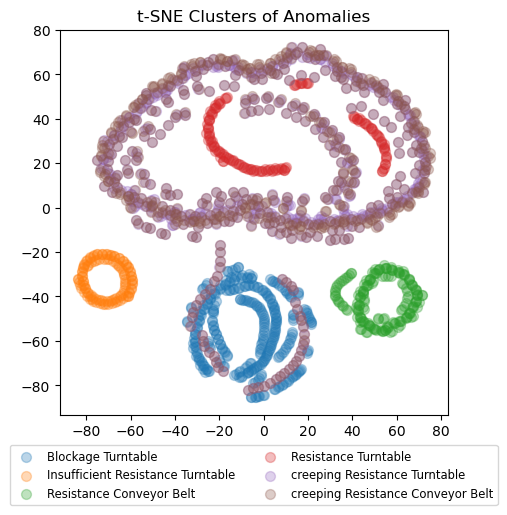

In [38]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [5, 5]

feature_vector_test_anormal_Resistance_schleichend_=feature_vector_test_anormal_Resistance_schleichend[len(mse_schleichend_nor_rondel):][::]
feature_vector_test_anormal_res_conv_belt_schleichend_=feature_vector_test_anormal_res_conv_belt_schleichend[len(mse_schleichend_nor_foeder):][::]


dim_rduction_function = TSNE(n_components=2, perplexity=10, random_state=42, init="random")

two_dim=dim_rduction_function.fit_transform(np.concatenate(( feature_vector_test_anormal_Resistance , feature_vector_test_anormal_Blockage, feature_vector_test_anormal_no_resistance, feature_vector_test_anormal_res_conv_belt, feature_vector_test_anormal_Resistance_schleichend_, feature_vector_test_anormal_res_conv_belt_schleichend_), axis=0))


first = len(feature_vector_test_anormal_Resistance) 
second = len(feature_vector_test_anormal_Blockage)
third = len(feature_vector_test_anormal_no_resistance)
fourth = len(feature_vector_test_anormal_res_conv_belt) 
fitht = len(feature_vector_test_anormal_Resistance_schleichend_)
sixth = len(feature_vector_test_anormal_res_conv_belt_schleichend_)

ranges = [[0,first],[first,first+second],[first+second, first+second+third],[first+second+third,first+second+third+fourth], [first+second+third+fourth,first+second+third+fourth+fitht], [first+second+third+fourth+fitht,first+second+third+fourth+fitht+sixth]]

for i in ranges:

    xs = np.array(two_dim[i[0]:i[1], 0])
    ys = np.array(two_dim[i[0]:i[1], 1])
    xs = np.array(xs)
    ys = np.array(ys)

    plt.scatter(xs, ys, alpha=0.3, cmap='viridis', s=50)


plt.legend(["Blockage Turntable", "Insufficient Resistance Turntable",  "Resistance Conveyor Belt", "Resistance Turntable", "creeping Resistance Turntable", "creeping Resistance Conveyor Belt" ], loc=8,bbox_to_anchor=(0.5, -0.25), ncol=2, fontsize='small')
plt.title("t-SNE Clusters of Anomalies")
plt.show()



(704,)
(704, 2)
KMeans Evaluation:
Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00

DBSCAN Evaluation:
Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00

Hierarchical Clustering Evaluation:
Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00

Gaussian Mixture Model Evaluation:
Adjusted Rand Index (ARI): 1.00
Normalized Mutual Information (NMI): 1.00


c:\Users\Fabia\anaconda3\envs\ML_TF210\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\Fabia\anaconda3\envs\ML_TF210\lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


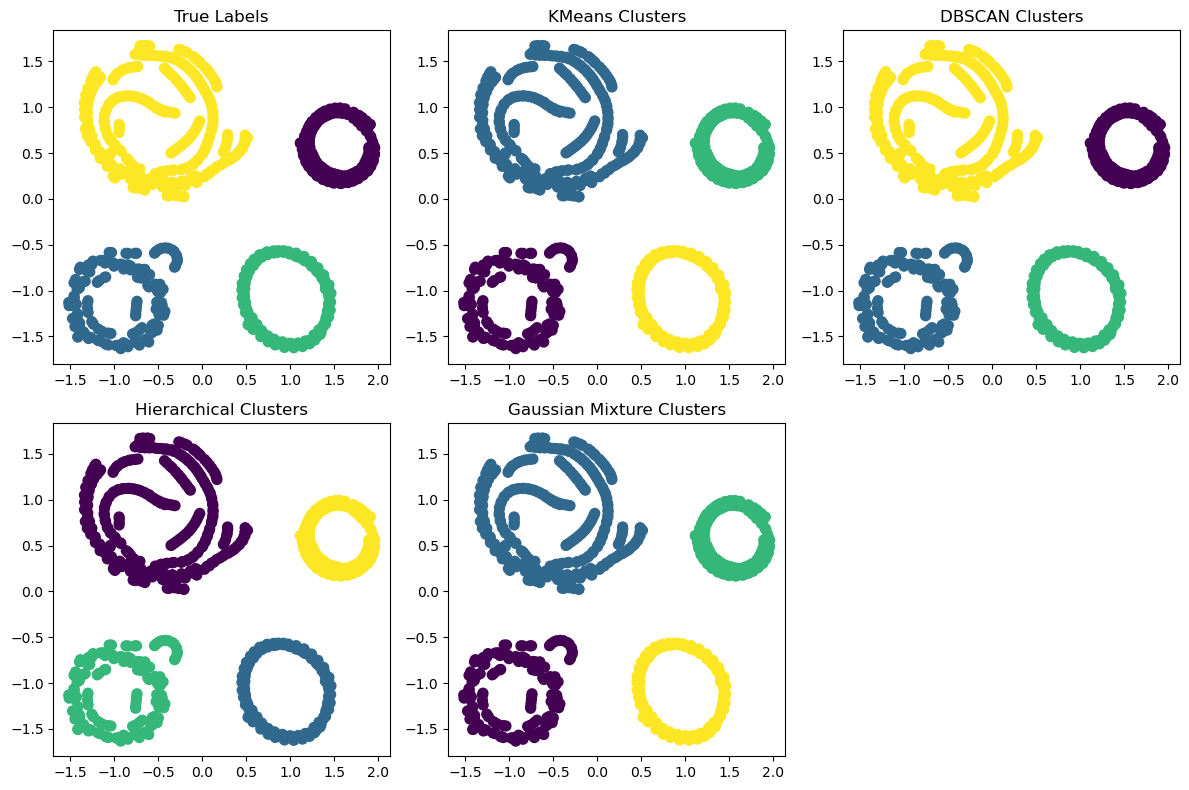

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# 1. Datensatz laden
# Hier ein Beispiel mit Zufallsdaten. Ersetze es durch deinen eigenen Datensatz.
# Dein Datensatz sollte "features" (Daten) und "labels" (echte Klassen) enthalten.
np.random.seed(42)


dim_rduction_function = TSNE(n_components=2, perplexity=10, random_state=42, init="random")

two_dim=dim_rduction_function.fit_transform(np.concatenate((feature_vector_test_anormal_Blockage, feature_vector_test_anormal_no_resistance,feature_vector_test_anormal_res_conv_belt, feature_vector_test_anormal_Resistance),axis=0))

data = two_dim


labels = np.concatenate((np.zeros(len(feature_vector_test_anormal_Blockage)),np.zeros(len(feature_vector_test_anormal_no_resistance))+1,
                        np.zeros(len(feature_vector_test_anormal_res_conv_belt))+2,np.zeros(len(feature_vector_test_anormal_Resistance))+3),axis=0)


print(labels.shape)
print(data.shape)

# 2. Datenvorverarbeitung
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# 3. Clustering-Algorithmen
# KMeans
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_clusters = kmeans.fit_predict(data_scaled)

# DBSCAN
dbscan = DBSCAN(eps=0.3, min_samples=5)
dbscan_clusters = dbscan.fit_predict(data_scaled)

# Hierarchisches Clustering
agglo = AgglomerativeClustering(n_clusters=4)
agglo_clusters = agglo.fit_predict(data_scaled)

# Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_clusters = gmm.fit_predict(data_scaled)

# 4. Evaluierung der Ergebnisse
def evaluate_clustering(true_labels, predicted_labels):
    ari = adjusted_rand_score(true_labels, predicted_labels)
    nmi = normalized_mutual_info_score(true_labels, predicted_labels)
    print(f"Adjusted Rand Index (ARI): {ari:.2f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.2f}")
    return ari, nmi

print("KMeans Evaluation:")
evaluate_clustering(labels, kmeans_clusters)

print("\nDBSCAN Evaluation:")
evaluate_clustering(labels, dbscan_clusters)

print("\nHierarchical Clustering Evaluation:")
evaluate_clustering(labels, agglo_clusters)

print("\nGaussian Mixture Model Evaluation:")
evaluate_clustering(labels, gmm_clusters)

# 5. Visualisierung
# Reduktion der Dimensionen mit PCA für 2D-Plot
pca = PCA(n_components=2)
data_2d = pca.fit_transform(data_scaled)

plt.figure(figsize=(12, 8))

# Echte Labels
plt.subplot(231)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=labels, cmap='viridis', s=50)
plt.title("True Labels")

# KMeans
plt.subplot(232)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=kmeans_clusters, cmap='viridis', s=50)
plt.title("KMeans Clusters")

# DBSCAN
plt.subplot(233)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=dbscan_clusters, cmap='viridis', s=50)
plt.title("DBSCAN Clusters")

# Hierarchisches Clustering
plt.subplot(234)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=agglo_clusters, cmap='viridis', s=50)
plt.title("Hierarchical Clusters")

# Gaussian Mixture
plt.subplot(235)
plt.scatter(data_2d[:, 0], data_2d[:, 1], c=gmm_clusters, cmap='viridis', s=50)
plt.title("Gaussian Mixture Clusters")

plt.tight_layout()
plt.show()

In [31]:
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score
import numpy as np

def clustering_accuracy(true_labels, predicted_labels):
    """
    Berechnet die Genauigkeit der Cluster-Zuordnung basierend auf den wahren Labels.
    """
    true_labels=np.array(true_labels, dtype=np.int32)
    predicted_labels=np.array(predicted_labels, dtype=np.int32)
    # Erstelle eine Verwechslungs-Matrix
    n_classes = len(np.unique(true_labels))
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)
    
    for true_label, pred_label in zip(true_labels, predicted_labels):
        confusion_matrix[true_label, pred_label] += 1

    # Finde die beste Zuordnung mit Hungarian-Methode
    row_ind, col_ind = linear_sum_assignment(-confusion_matrix)

    # Berechne die Genauigkeit basierend auf der Zuordnung
    total_correct = confusion_matrix[row_ind, col_ind].sum()
    accuracy = total_correct / len(true_labels)
    
    return accuracy, confusion_matrix

# Berechnung der Genauigkeit für jeden Algorithmus
print("KMeans Accuracy:")
kmeans_accuracy, kmeans_conf_matrix = clustering_accuracy(labels, kmeans_clusters)
print(f"Accuracy: {kmeans_accuracy:.2f}")
print("Confusion Matrix:\n", kmeans_conf_matrix)

print("\nDBSCAN Accuracy:")
dbscan_accuracy, dbscan_conf_matrix = clustering_accuracy(labels, dbscan_clusters)
print(f"Accuracy: {dbscan_accuracy:.2f}")
print("Confusion Matrix:\n", dbscan_conf_matrix)

print("\nHierarchical Clustering Accuracy:")
agglo_accuracy, agglo_conf_matrix = clustering_accuracy(labels, agglo_clusters)
print(f"Accuracy: {agglo_accuracy:.2f}")
print("Confusion Matrix:\n", agglo_conf_matrix)

print("\nGaussian Mixture Accuracy:")
gmm_accuracy, gmm_conf_matrix = clustering_accuracy(labels, gmm_clusters)
print(f"Accuracy: {gmm_accuracy:.2f}")
print("Confusion Matrix:\n", gmm_conf_matrix)

KMeans Accuracy:
Accuracy: 1.00
Confusion Matrix:
 [[  0   0 112   0]
 [160   0   0   0]
 [  0   0   0 128]
 [  0 304   0   0]]

DBSCAN Accuracy:
Accuracy: 1.00
Confusion Matrix:
 [[112   0   0   0]
 [  0 160   0   0]
 [  0   0 128   0]
 [  0   0   0 304]]

Hierarchical Clustering Accuracy:
Accuracy: 1.00
Confusion Matrix:
 [[  0   0   0 112]
 [  0   0 160   0]
 [  0 128   0   0]
 [304   0   0   0]]

Gaussian Mixture Accuracy:
Accuracy: 1.00
Confusion Matrix:
 [[  0   0 112   0]
 [160   0   0   0]
 [  0   0   0 128]
 [  0 304   0   0]]


In [32]:
normal_score = np.mean(mse_normal[:,:],axis=-1)
anormal_score =  np.append(np.append(np.mean(mse_anomlie[0][:,:],axis=-1),np.mean(mse_anomlie[1][:,:])) , np.mean(mse_anomlie[2][:,:]) )

scores = np.append( normal_score, anormal_score)
label = np.append( np.zeros(len(normal_score)) ,np.ones(len(anormal_score)) )


In [33]:
mean_score=scores
thresholds_for_f1=np.arange(0,0.1,0.0001)
anomalie_pred_fro_each_threshold=[]
anomalie_pred_fro_each_threshold= [[0 if (mse<threshold) else 1 for mse in mean_score] for threshold in thresholds_for_f1]

f1_scores=[]
for anomalies_for_each_treshold in anomalie_pred_fro_each_threshold: 
    f1_scores+=[sklearn.metrics.f1_score(label, anomalies_for_each_treshold)]


    #print("\n")

print("threshold",thresholds_for_f1[np.argmax(f1_scores)])
print("best f1", max(f1_scores))

threshold 0.0048000000000000004
best f1 0.8996539792387543
